In [1]:
# --- Header dan Impor Library ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Untuk Association Rule Mining
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [3]:
# Untuk menghindari warning
import warnings
warnings.filterwarnings('ignore')

In [4]:
print("Library berhasil diimpor.")
print("---")

Library berhasil diimpor.
---


In [5]:
# --- 1. Muat Data CSV ---
print("Memuat data dari file CSV...")
try:
    df_customer = pd.read_csv('dataset/customer.csv')
    df_product = pd.read_csv('dataset/product.csv')
    df_transaction_details = pd.read_csv('dataset/transaction_details.csv')
    df_date = pd.read_csv('dataset/date.csv') # Bisa digunakan untuk fitur tanggal di masa depan jika diperlukan
    print("Data berhasil dimuat.")
except FileNotFoundError as e:
    print(f"Error: {e}. Pastikan semua file CSV (customer.csv, product.csv, transaction_details.csv, date.csv) sudah diunggah.")
    exit()

Memuat data dari file CSV...
Data berhasil dimuat.


In [6]:
print("---")

# --- Bagian 1: Segmentasi Pelanggan Menggunakan Clustering (K-Means) ---
print("Memulai Segmentasi Pelanggan (Clustering)...")

# 2. Feature Engineering (Pelanggan)
print("Melakukan Feature Engineering untuk pelanggan...")
# Gabungkan transaksi dengan produk untuk mendapatkan detail kategori/brand
df_transactions_with_product = pd.merge(df_transaction_details, df_product, on='product_id', how='left')

---
Memulai Segmentasi Pelanggan (Clustering)...
Melakukan Feature Engineering untuk pelanggan...


In [7]:
# Hitung Total Revenue per customer
customer_revenue = df_transactions_with_product.groupby('customer_id')['total'].sum().reset_index()
customer_revenue.rename(columns={'total': 'Total_Revenue'}, inplace=True)


In [8]:
# Hitung Transaction Count per customer
customer_transaction_count = df_transactions_with_product.groupby('customer_id')['transaction_id'].nunique().reset_index()
customer_transaction_count.rename(columns={'transaction_id': 'Transaction_Count'}, inplace=True)

In [9]:
# Hitung Average Quantity per transaction per customer
customer_avg_quantity = df_transactions_with_product.groupby('customer_id')['quantity'].mean().reset_index()
customer_avg_quantity.rename(columns={'quantity': 'Avg_Quantity_Per_Transaction'}, inplace=True)

In [10]:
# Hitung Unique Products Purchased per customer
customer_unique_products = df_transactions_with_product.groupby('customer_id')['product_id'].nunique().reset_index()
customer_unique_products.rename(columns={'product_id': 'Unique_Products_Purchased'}, inplace=True)

In [11]:
# --- PERBAIKAN: Menggunakan df_date untuk mendapatkan tanggal sebenarnya ---
# Gabungkan transaction_details dengan df_date untuk mendapatkan 'full_date'
df_transactions_with_date = pd.merge(df_transaction_details, df_date[['date_id', 'full_date']], on='date_id', how='left')

In [12]:
# Konversi 'full_date' ke datetime
df_transactions_with_date['transaction_date'] = pd.to_datetime(df_transactions_with_date['full_date'])

In [13]:
# Calculate Recency
snapshot_date = df_transactions_with_date['transaction_date'].max() + pd.Timedelta(days=1)
rfm_df = df_transactions_with_date.groupby('customer_id').agg(
    Recency=('transaction_date', lambda date: (snapshot_date - date.max()).days),
    Frequency=('transaction_id', 'nunique'),
    Monetary=('total', 'sum')
).reset_index()

In [14]:
# Merge all customer features
df_customer_features = pd.merge(df_customer, customer_revenue, on='customer_id', how='left')
df_customer_features = pd.merge(df_customer_features, customer_transaction_count, on='customer_id', how='left')
df_customer_features = pd.merge(df_customer_features, customer_avg_quantity, on='customer_id', how='left')
df_customer_features = pd.merge(df_customer_features, customer_unique_products, on='customer_id', how='left')
df_customer_features = pd.merge(df_customer_features, rfm_df, on='customer_id', how='left')

In [15]:
# Drop irrelevant columns for clustering (e.g., identifiers, text)
customer_clustering_df = df_customer_features.drop(columns=[
    'customer_id', 'name', 'email', 'address', 'phone_number', 'preferred_product_id' # preferred_product_id could be useful if treated as categorical ID, but skipping for initial clustering simplicity
])

In [16]:
# 3. Pra-pemrosesan untuk Clustering
print("Melakukan pra-pemrosesan untuk clustering...")
# Identify numerical and categorical features for clustering
clustering_numerical_features = ['age', 'Total_Revenue', 'Transaction_Count',
                                 'Avg_Quantity_Per_Transaction', 'Unique_Products_Purchased',
                                 'Recency', 'Frequency', 'Monetary']
clustering_categorical_features = ['city'] # Add other categorical features if needed

Melakukan pra-pemrosesan untuk clustering...


In [17]:
# Filter features to only include those present
clustering_numerical_features = [f for f in clustering_numerical_features if f in customer_clustering_df.columns]
clustering_categorical_features = [f for f in clustering_categorical_features if f in customer_clustering_df.columns]

In [18]:
# Handle missing values (fill with 0 for aggregated stats, median/mode for others)
for col in ['Total_Revenue', 'Transaction_Count', 'Avg_Quantity_Per_Transaction', 'Unique_Products_Purchased', 'Recency', 'Frequency', 'Monetary']:
    if col in customer_clustering_df.columns:
        customer_clustering_df[col] = customer_clustering_df[col].fillna(0) # Fill aggregated stats with 0 for no transactions
for col in ['age']:
    if col in customer_clustering_df.columns:
        customer_clustering_df[col] = customer_clustering_df[col].fillna(customer_clustering_df[col].median())
for col in clustering_categorical_features:
    if col in customer_clustering_df.columns:
        customer_clustering_df[col] = customer_clustering_df[col].fillna('Unknown')

In [40]:
customer_clustering_df.columns

Index(['age', 'city', 'Total_Revenue', 'Transaction_Count',
       'Avg_Quantity_Per_Transaction', 'Unique_Products_Purchased', 'Recency',
       'Frequency', 'Monetary', 'Cluster'],
      dtype='object')

In [19]:
# Create preprocessing pipeline for clustering
preprocessor_clustering = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), clustering_numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), clustering_categorical_features)
    ],
    remainder='drop'
)

In [41]:
import joblib

# Simpan preprocessor_clustering ke file .pkl
joblib.dump(preprocessor_clustering, 'preprocessor_clustering.pkl')
print("Preprocessing pipeline berhasil disimpan ke file 'preprocessor_clustering.pkl'.")

Preprocessing pipeline berhasil disimpan ke file 'preprocessor_clustering.pkl'.


In [20]:
# Apply preprocessing
X_clustered = preprocessor_clustering.fit_transform(customer_clustering_df)
print(f"Dimensi data setelah pra-pemrosesan: {X_clustered.shape}")

Dimensi data setelah pra-pemrosesan: (50000, 15)


In [39]:
X_clustered

array([[-1.04956108e+00, -1.32866818e+00, -1.16073720e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.30456149e-01,  1.08195325e+00,  1.74125090e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.17134303e-01,  7.19205836e-01,  1.16085328e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.58238714e-01, -1.39462225e+00, -5.80339579e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.48996366e-02, -1.31135524e+00, -1.16073720e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.90665492e-01, -3.92944747e-01,  5.80397619e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [21]:
# 4. Clustering (K-Means) - Menentukan Jumlah Cluster (Elbow Method Visual)
print("Menentukan jumlah cluster optimal menggunakan Elbow Method...")
sse = []
silhouette_scores = []
# Range k yang masuk akal, hindari k=1
k_range = range(2, min(11, X_clustered.shape[0])) # Jangan terlalu banyak k jika data kecil

Menentukan jumlah cluster optimal menggunakan Elbow Method...


In [22]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init for stability
    kmeans.fit(X_clustered)
    sse.append(kmeans.inertia_)
    # Calculate Silhouette Score only if there are at least 2 clusters
    if k > 1:
        silhouette_scores.append(silhouette_score(X_clustered, kmeans.labels_))

  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 546, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1022, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1491, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


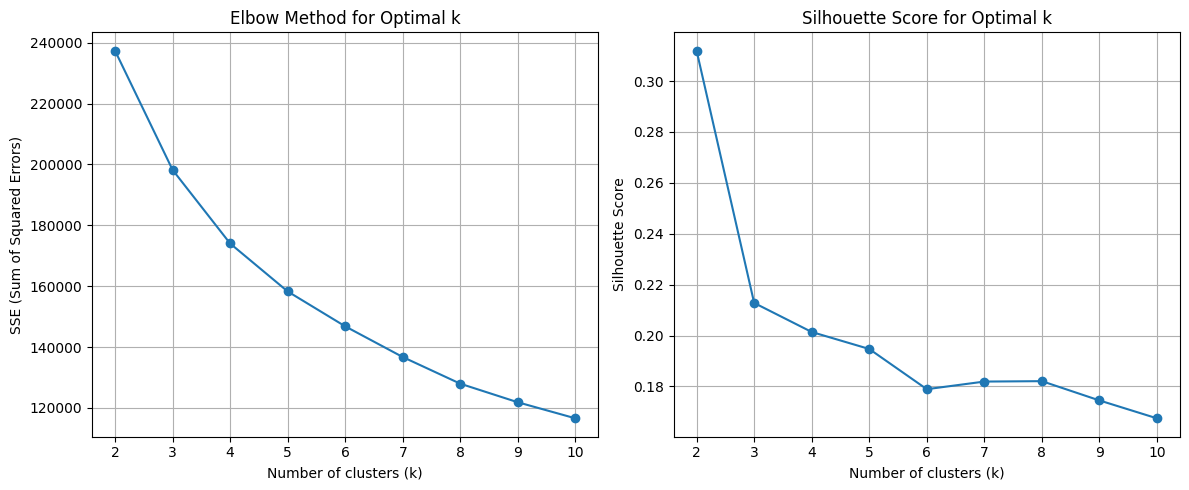

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.grid(True)

plt.subplot(1, 2, 2)
# Adjust k_range for silhouette_scores as it starts from k=2
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Berdasarkan Elbow Method, misalkan kita pilih k=3 (Anda bisa menyesuaikan ini secara visual)
optimal_k = 4
print(f"Dipilih {optimal_k} cluster berdasarkan Elbow Method (visualisasi di atas).")

Dipilih 4 cluster berdasarkan Elbow Method (visualisasi di atas).


In [25]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_clustering_df['Cluster'] = kmeans_final.fit_predict(X_clustered)

In [26]:
# 5. Analisis Cluster
print("\nMelakukan analisis karakteristik setiap cluster...")
cluster_analysis = customer_clustering_df.groupby('Cluster').agg(
    Count=('age', 'size'), # size to get the number of customers in each cluster
    Avg_Age=('age', 'mean'),
    Avg_Total_Revenue=('Total_Revenue', 'mean'),
    Avg_Transaction_Count=('Transaction_Count', 'mean'),
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean'),
    Most_Common_City=('city', lambda x: x.mode()[0] if not x.empty else 'N/A')
).round(2)


Melakukan analisis karakteristik setiap cluster...


In [27]:
print("\nKarakteristik Setiap Cluster:")
print(cluster_analysis)

print("\nSegmentasi Pelanggan Selesai.")
print("---")

# --- Bagian 2: Analisis Keranjang Belanja Menggunakan Aturan Asosiasi (Apriori) ---
print("Memulai Analisis Keranjang Belanja (Association Rule Mining)...")

# 2. Transformasi Data
# Gabungkan transaction_details dengan product untuk mendapatkan nama produk
df_basket = pd.merge(df_transaction_details, df_product[['product_id', 'product_name']], on='product_id', how='left')


Karakteristik Setiap Cluster:
         Count  Avg_Age  Avg_Total_Revenue  Avg_Transaction_Count  \
Cluster                                                             
0         9821    43.96       9.272273e+07                   2.47   
1         8442    44.21       2.156245e+08                   6.66   
2        13039    43.98       5.833507e+07                   2.59   
3        18698    43.97       1.350416e+08                   4.58   

         Avg_Recency  Avg_Frequency  Avg_Monetary Most_Common_City  
Cluster                                                             
0                1.0           2.47  9.272273e+07          Jakarta  
1                1.0           6.66  2.156245e+08          Jakarta  
2                1.0           2.59  5.833507e+07          Jakarta  
3                1.0           4.58  1.350416e+08          Jakarta  

Segmentasi Pelanggan Selesai.
---
Memulai Analisis Keranjang Belanja (Association Rule Mining)...


In [28]:
# Buat list of lists, di mana setiap sublist adalah keranjang belanja (transaksi)
# Groups transactions by transaction_id and puts all product_names into a list
transactions_list = df_basket.groupby('transaction_id')['product_name'].apply(list).tolist()
print(f"Jumlah transaksi unik untuk analisis keranjang belanja: {len(transactions_list)}")

Jumlah transaksi unik untuk analisis keranjang belanja: 86480


In [29]:
# Ubah list of lists menjadi format One-Hot Encoded DataFrame untuk Apriori
# mlxtend.preprocessing.TransactionEncoder bisa digunakan jika ada
# Atau, buat secara manual:
from mlxtend.preprocessing import TransactionEncoder

In [30]:
te = TransactionEncoder()
te_ary = te.fit(transactions_list).transform(transactions_list)
df_apriori = pd.DataFrame(te_ary, columns=te.columns_)
print("\nDataFrame untuk Apriori (One-Hot Encoded) Head:")
print(df_apriori.head())
print(f"Dimensi DataFrame Apriori: {df_apriori.shape}")


DataFrame untuk Apriori (One-Hot Encoded) Head:
   iPhone 13  iPhone 13 Pro  iPhone 13 Pro Max  iPhone 14  iPhone 14 Plus  \
0       True           True              False      False           False   
1      False          False              False      False           False   
2      False           True              False      False           False   
3       True          False               True      False           False   
4      False          False               True      False           False   

   iPhone 14 Pro  iPhone 14 Pro Max  iPhone 15  iPhone 15 Plus  iPhone 15 Pro  \
0          False              False      False            True          False   
1           True              False      False            True          False   
2          False              False      False           False          False   
3          False              False      False           False           True   
4          False              False       True           False          False   

 

In [31]:
# 3. Terapkan Apriori
print("\nMenerapkan algoritma Apriori untuk menemukan itemset sering muncul...")
# Minimal support adalah ambang batas frekuensi kemunculan itemset
# Sesuaikan min_support sesuai kebutuhan dan ukuran data Anda
frequent_itemsets = apriori(df_apriori, min_support=0.01, use_colnames=True) # min_support 0.01 = 1% dari transaksi
print(f"Jumlah itemset sering muncul yang ditemukan: {len(frequent_itemsets)}")
print("\nFrequent Itemsets Head:")
print(frequent_itemsets.head())


Menerapkan algoritma Apriori untuk menemukan itemset sering muncul...
Jumlah itemset sering muncul yang ditemukan: 78

Frequent Itemsets Head:
    support             itemsets
0  0.175902          (iPhone 13)
1  0.177475      (iPhone 13 Pro)
2  0.176677  (iPhone 13 Pro Max)
3  0.179001          (iPhone 14)
4  0.177058     (iPhone 14 Plus)


In [32]:
# 4. Filter dan Interpretasi Aturan
print("\nMenghasilkan aturan asosiasi...")
# min_confidence: ambang batas keyakinan
# min_lift: ambang batas lift
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1) # min_threshold > 1.0 indicates positive correlation
rules = rules.sort_values(['lift'], ascending=False)

print(f"Jumlah aturan asosiasi yang ditemukan: {len(rules)}")
print("\nAturan Asosiasi Teratas (berdasarkan Lift):")
print(rules.head(10))

print("\nAnalisis Keranjang Belanja Selesai.")
print("---")

print("\nSemua model unsupervised telah dibuat dan dieksekusi.")
print("Hasilnya mencakup karakteristik cluster pelanggan dan aturan asosiasi pembelian produk.")


Menghasilkan aturan asosiasi...
Jumlah aturan asosiasi yang ditemukan: 0

Aturan Asosiasi Teratas (berdasarkan Lift):
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []

Analisis Keranjang Belanja Selesai.
---

Semua model unsupervised telah dibuat dan dieksekusi.
Hasilnya mencakup karakteristik cluster pelanggan dan aturan asosiasi pembelian produk.


In [33]:
df_apriori.to_csv('encoded_model2_dataset.csv', index=False)

In [34]:
# --- Hasil Evaluasi Model Unsupervised ---

print("=== HASIL EVALUASI MODEL UNSUPERVISED ===\n")

# 1. Evaluasi Clustering (K-Means)
print(">> Evaluasi Clustering (K-Means)")
print(f"- Jumlah cluster dipilih: {optimal_k}")
print(f"- SSE (Sum of Squared Errors) untuk tiap k: {sse}")
print(f"- Silhouette Scores untuk tiap k: {silhouette_scores}")
print("\nKarakteristik Setiap Cluster:")
print(cluster_analysis)
print("\nInterpretasi:")
print("Silhouette score yang lebih tinggi menunjukkan cluster yang lebih baik. "
    "SSE yang menurun tajam lalu melandai menandakan jumlah cluster optimal (lihat Elbow Method). "
    "Karakteristik cluster dapat digunakan untuk memahami segmentasi pelanggan.")

print("\n>> Evaluasi Association Rule Mining (Apriori)")
print(f"- Jumlah frequent itemsets ditemukan: {len(frequent_itemsets)}")
print(f"- Jumlah aturan asosiasi ditemukan: {len(rules)}")
if len(rules) > 0:
    print("\nAturan asosiasi teratas (berdasarkan lift):")
    print(rules.head(5))
else:
    print("\nTidak ditemukan aturan asosiasi dengan lift > 1.1 pada parameter saat ini.")

print("\nCatatan:")
print("- Evaluasi clustering menggunakan Silhouette Score dan SSE.")
print("- Evaluasi association rule mining berdasarkan jumlah aturan dan nilai lift/confidence.")
print("- Parameter dapat disesuaikan untuk mendapatkan hasil yang lebih optimal.")

=== HASIL EVALUASI MODEL UNSUPERVISED ===

>> Evaluasi Clustering (K-Means)
- Jumlah cluster dipilih: 4
- SSE (Sum of Squared Errors) untuk tiap k: [237354.16747544316, 198204.66604833657, 174031.53110043108, 158281.45918784628, 146817.34214340843, 136733.60829944134, 127971.71447063178, 121873.43240069869, 116600.12123213439]
- Silhouette Scores untuk tiap k: [np.float64(0.3119327079493524), np.float64(0.2128301601001856), np.float64(0.2014151339270439), np.float64(0.19473535316936508), np.float64(0.17894142215436085), np.float64(0.18193438833483774), np.float64(0.18209572687518993), np.float64(0.17451907131934474), np.float64(0.16748585962783874)]

Karakteristik Setiap Cluster:
         Count  Avg_Age  Avg_Total_Revenue  Avg_Transaction_Count  \
Cluster                                                             
0         9821    43.96       9.272273e+07                   2.47   
1         8442    44.21       2.156245e+08                   6.66   
2        13039    43.98       5.833

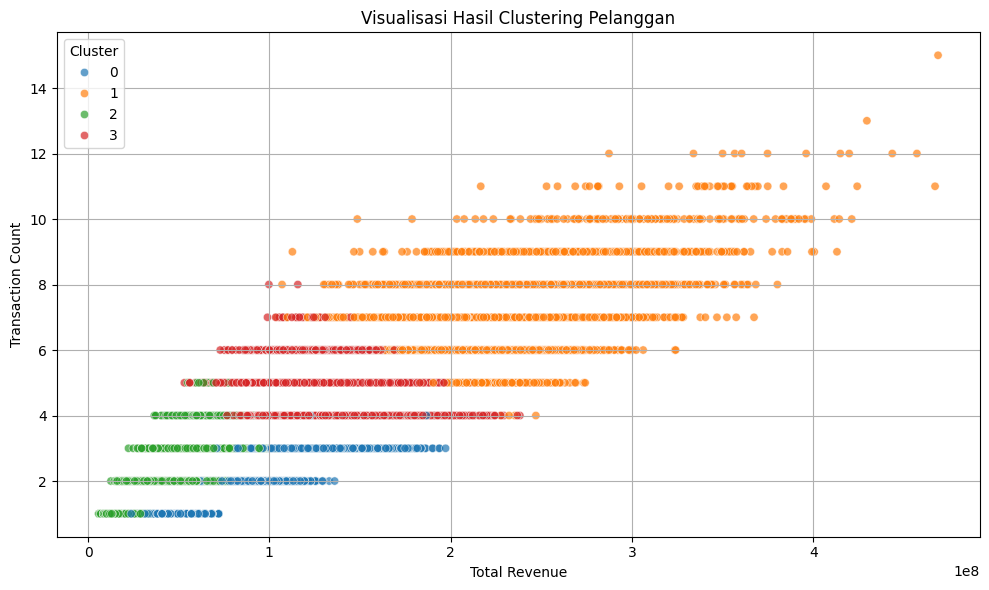

In [42]:
# Visualisasi hasil clustering dengan scatter plot (menggunakan dua fitur utama)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=customer_clustering_df,
    x='Total_Revenue',
    y='Transaction_Count',
    hue='Cluster',
    palette='tab10',
    alpha=0.7
)
plt.title('Visualisasi Hasil Clustering Pelanggan')
plt.xlabel('Total Revenue')
plt.ylabel('Transaction Count')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
import joblib

# Simpan model KMeans dan hasil klustering ke file .pkl
output = {
    'model': kmeans_final,
    'clustered_data': customer_clustering_df
}
joblib.dump(output, 'kmeans_model.pkl')
print("Model KMeans dan hasil klustering berhasil disimpan ke file 'kmeans_model.pkl'.")

Model KMeans dan hasil klustering berhasil disimpan ke file 'kmeans_model.pkl'.


In [35]:
import joblib

# Simpan model KMeans final ke file .pkl
joblib.dump(kmeans_final, 'kmeans_model.pkl')
print("Model KMeans berhasil disimpan ke file 'kmeans_model.pkl'.")

Model KMeans berhasil disimpan ke file 'kmeans_model.pkl'.


In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Konfigurasi halaman
st.set_page_config(
    page_title="Segmentasi Pelanggan",
    page_icon="👥",
    layout="wide"
)

# Memuat model
@st.cache_resource
def load_model():
    with open('kmeans_model.pkl', 'rb') as f:
        model = joblib.load(f)
    return model

# Load model
model = load_model()

# Judul aplikasi
st.title("👥 Segmentasi Pelanggan")
st.markdown("### Analisis karakteristik pelanggan menggunakan K-Means Clustering")

# Membuat dua kolom
col1, col2 = st.columns(2)

with col1:
    st.subheader("Informasi Pelanggan")
    age = st.number_input("Usia", min_value=18, max_value=100, value=30)
    city = st.selectbox("Kota", ["Jakarta", "Surabaya", "Bandung", "Medan", "Other"])
    total_revenue = st.number_input("Total Pendapatan", min_value=0.0, value=1000000.0)
    transaction_count = st.number_input("Jumlah Transaksi", min_value=0, value=5)

with col2:
    st.subheader("Informasi Transaksi")
    avg_quantity = st.number_input("Rata-rata Jumlah Item per Transaksi", min_value=0.0, value=2.0)
    unique_products = st.number_input("Jumlah Produk Unik yang Dibeli", min_value=0, value=3)
    recency = st.number_input("Recency (hari sejak transaksi terakhir)", min_value=0, value=30)
    monetary = st.number_input("Nilai Monetary (Total Pembelanjaan)", min_value=0.0, value=500000.0)

# Tombol prediksi
if st.button("Analisis Segmen Pelanggan"):
    try:
        # Membuat dataframe input
        input_data = pd.DataFrame({
            'age': [age],
            'city': [city],
            'Total_Revenue': [total_revenue],
            'Transaction_Count': [transaction_count],
            'Avg_Quantity_Per_Transaction': [avg_quantity],
            'Unique_Products_Purchased': [unique_products],
            'Recency': [recency],
            'Frequency': [transaction_count],  # sama dengan Transaction_Count
            'Monetary': [monetary]
        })

        # Melakukan prediksi
        cluster = model.predict(input_data)

        # Menampilkan hasil
        st.markdown("### Hasil Analisis")
        
        # Menentukan karakteristik cluster
        cluster_characteristics = {
            0: "Pelanggan Reguler",
            1: "Pelanggan Premium",
            2: "Pelanggan Casual",
            3: "Pelanggan Potensial"
        }
        
        cluster_descriptions = {
            0: "Pelanggan yang melakukan transaksi secara teratur dengan nilai sedang",
            1: "Pelanggan loyal dengan nilai transaksi tinggi dan frekuensi pembelian tinggi",
            2: "Pelanggan dengan frekuensi pembelian rendah dan nilai transaksi rendah",
            3: "Pelanggan dengan potensi untuk ditingkatkan ke segmen premium"
        }

        # Menampilkan hasil dengan format yang lebih menarik
        st.success(f"Pelanggan ini termasuk dalam segmen: {cluster_characteristics[cluster[0]]}")
        
        # Menampilkan deskripsi
        st.info(f"Karakteristik Segmen: {cluster_descriptions[cluster[0]]}")
        
        # Visualisasi metrik pelanggan
        st.subheader("Visualisasi Metrik Pelanggan")
        
        # Radar chart untuk metrik pelanggan
        metrics = ['Recency', 'Frequency', 'Monetary', 'Age', 'Transaction_Count']
        values = [recency/100, transaction_count/10, monetary/1000000, age/100, transaction_count/10]
        
        # Create radar chart
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
        angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
        values = np.concatenate((values, [values[0]]))  # complete the loop
        angles = np.concatenate((angles, [angles[0]]))  # complete the loop
        
        ax.plot(angles, values)
        ax.fill(angles, values, alpha=0.25)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics)
        plt.title("Profil Metrik Pelanggan")
        
        st.pyplot(fig)

    except Exception as e:
        st.error(f"Terjadi kesalahan: {str(e)}")
        st.write("Mohon periksa kembali data yang dimasukkan")

# Informasi tambahan di sidebar
st.sidebar.header("Informasi Model")
st.sidebar.markdown("""
### Tentang Model Clustering
Model ini menggunakan algoritma K-Means untuk mensegmentasi pelanggan berdasarkan:
- Usia
- Lokasi
- Perilaku pembelian
- Nilai transaksi
- Frekuensi pembelian
""")

# Footer
st.markdown("---")
st.markdown("Dibuat dengan ❤️ menggunakan Streamlit")